<a href="https://colab.research.google.com/github/gizemnurbektas/Disaster-Tweets-ML-Model/blob/main/tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from collections import defaultdict
from wordcloud import WordCloud
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tweets.csv to tweets.csv


# EDA

In [ ]:
df = pd.read_csv("tweets.csv")
df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [ ]:
print("Shape:",df.shape)
print ("Columns:",df.columns.tolist())

Shape: (11370, 5)
Columns: ['id', 'keyword', 'location', 'text', 'target']


In [ ]:
df.isnull().sum()

,0
id,0
keyword,0
location,3418
text,0
target,0


Orijinal df DataFrame in içindeki eksik değerlere sahip bütün sayıları siler.

In [ ]:
print("Satır sayısı:", df.shape[0])
print("Sütun sayısı:", df.shape[1])

print(df.describe(include='all'))

Satır sayısı: 11370
Sütun sayısı: 5
                  id       keyword       location  \
count   11370.000000         11370           7952   
unique           NaN           219           4504   
top              NaN  thunderstorm  United States   
freq             NaN            93             96   
mean     5684.500000           NaN            NaN   
std      3282.380615           NaN            NaN   
min         0.000000           NaN            NaN   
25%      2842.250000           NaN            NaN   
50%      5684.500000           NaN            NaN   
75%      8526.750000           NaN            NaN   
max     11369.000000           NaN            NaN   

                                                     text        target  
count                                               11370  11370.000000  
unique                                              11223           NaN  
top     We wanted to entertain you all with a good mov...           NaN  
freq                           

count gözlem sayısı,unique benzersiz değer sayısı,top en sık görülen değer,freq o değerin frekansı.std standart sapma mean ortalama

In [ ]:
df["text"] = df["text"].astype(str)
df["text_length"] = df["text"].apply(len)
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

print(df[["text_length", "word_count"]].describe())


        text_length    word_count
count  11370.000000  11370.000000
mean     107.571944     17.166139
std       30.135399      5.510808
min        5.000000      1.000000
25%       94.000000     14.000000
50%      119.000000     18.000000
75%      126.000000     21.000000
max      149.000000     32.000000


text sütunundaki tüm değerleri zorunlu olarak Python str (metin) tipine çevirir.Böylece boş/NaN kalırsa bile .apply(len) vb. işlemler hata vermez.
Her bir text hücresi için Python len() fonksiyonunu çalıştırır.Tweet’in karakter sayısını verir.Sonucu yeni bir text_length sütununa yazar.


In [ ]:
class_counts = df["target"].value_counts()
print("Not Disaster (0):", class_counts[0])
print("Disaster (1):", class_counts[1])

Not Disaster (0): 9256
Disaster (1): 2114


Sonuç, indeksinde etiket değeri (0 veya 1), değerinde o etiketten kaç adet bulunduğu bilgisi olan bir Pandas Series olur.

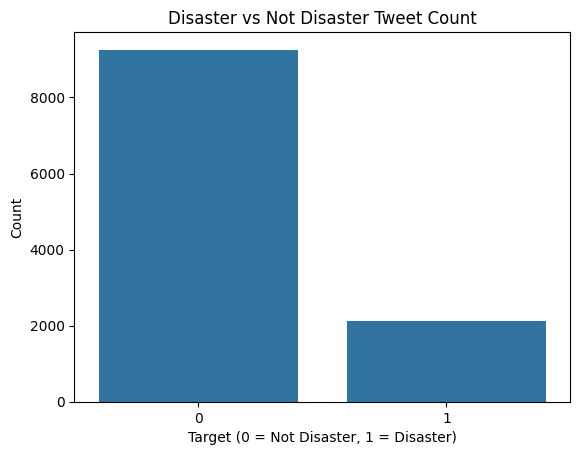

In [ ]:
sns.countplot(data=df, x="target")
plt.title("Disaster vs Not Disaster Tweet Count")
plt.xlabel("Target (0 = Not Disaster, 1 = Disaster)")
plt.ylabel("Count")
plt.show()

In [ ]:
null_counts = df.isnull().sum()
null_percent = null_counts / len(df) * 100
null_summary = pd.DataFrame({
    'null_count': null_counts,
    'null_percent': null_percent

})
total_by_class = df['target'].value_counts().to_dict()

rows = []
for col in df.columns:
    for cls, class_total in total_by_class.items():
        null_in_class = df.loc[df['target'] == cls, col].isnull().sum()
        pct_of_class = null_in_class / class_total * 100
        pct_of_total = null_in_class / len(df) * 100
        rows.append({
            'column': col,
            'class': cls,
            'null_count': null_in_class,
            'percent_of_class': round(pct_of_class, 2),
            'percent_of_total': round(pct_of_total, 2)
        })
        null_by_class_df = pd.DataFrame(rows)


In [ ]:
print("\n=== Null Values Breakdown by Class ===")
print(null_by_class_df)



=== Null Values Breakdown by Class ===
         column  class  null_count  percent_of_class  percent_of_total
0            id      0           0              0.00              0.00
1            id      1           0              0.00              0.00
2       keyword      0           0              0.00              0.00
3       keyword      1           0              0.00              0.00
4      location      0        2835             30.63             24.93
5      location      1         583             27.58              5.13
6          text      0           0              0.00              0.00
7          text      1           0              0.00              0.00
8        target      0           0              0.00              0.00
9        target      1           0              0.00              0.00
10  text_length      0           0              0.00              0.00
11  text_length      1           0              0.00              0.00
12   word_count      0           0   

In [ ]:
print("\n=== Null Values Summary ===")
print(null_summary)


=== Null Values Summary ===
             null_count  null_percent
id                    0      0.000000
keyword               0      0.000000
location           3418     30.061566
text                  0      0.000000
target                0      0.000000
text_length           0      0.000000
word_count            0      0.000000


text.lower() → Tüm harfleri küçültür, böylece “Help” ile “help” aynı kabul edilir.

re.sub(r"http\S+", "", text) → Tweet içindeki URL’leri (http ile başlayan bitişik karakterleri) tamamen kaldırır.

re.sub(r"\s+", " ", text) → Birden fazla boşluğu tek boşluğa indirger, satır sonlarını da düzler.

re.sub(f"[{re.escape(string.punctuation)}]", "", text) → Tüm noktalama işaretlerini (.,!?;: vb.) metinden temizler.

" ".join(...) → Boşlukla bölünmüş her kelimeyi kontrol eder, eğer o kelime stop‑words kümesinde değilse clean_text içine ekler.
Orijinal text sütununu önce zorunlu olarak str yapıyor (NaN vb. sorun olmasın diye),

Sonra her satır için preprocess()’i çalıştırıp dönen temiz metni clean_text adlı yeni sütuna yazıyor.Hem orijinal hem de temizlenmiş metinleri yan yana göstererek dönüştürmenin doğruluğunu hızlıca kontrol edebilmeni sağlar.

Ne işe yarar?

URL’ler, fazla boşluklar, noktalama işaretleri ve anlamsal açıdan gereksiz stop‑word’ler metinden çıkarıldığı için sonraki tokenizasyon, vektörleştirme ve modelleme adımlarında “gürültü” azaltılır, gerçek sinyal (anahtar kelimeler) daha belirgin hale gelir.

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

df["clean_text"] = df["text"].astype(str).apply(preprocess)
df[["text", "clean_text"]].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,clean_text
0,"Communal violence in Bhainsa, Telangana. ""Ston...",communal violence bhainsa telangana stones pel...
1,Telangana: Section 144 has been imposed in Bha...,telangana section 144 imposed bhainsa january ...
2,Arsonist sets cars ablaze at dealership https:...,arsonist sets cars ablaze dealership
3,Arsonist sets cars ablaze at dealership https:...,arsonist sets cars ablaze dealership
4,"""Lord Jesus, your love brings freedom and pard...",lord jesus love brings freedom pardon fill hol...


In [ ]:
text_data = " ".join(df["clean_text"])


Bu kod parçası, target sütunundaki “Not Disaster” (0) ve “Disaster” (1) etiketlerinin frekanslarını pandas ve seaborn yerine doğrudan matplotlib üzerinden çubuk grafik olarak çizer


=== Top 10 Keywords per Class (from text) ===
Class 0: [('the', 6259), ('t', 5474), ('https', 4499), ('co', 4462), ('to', 3669), ('a', 3435), ('of', 2893), ('i', 2721), ('and', 2589), ('in', 2369)]


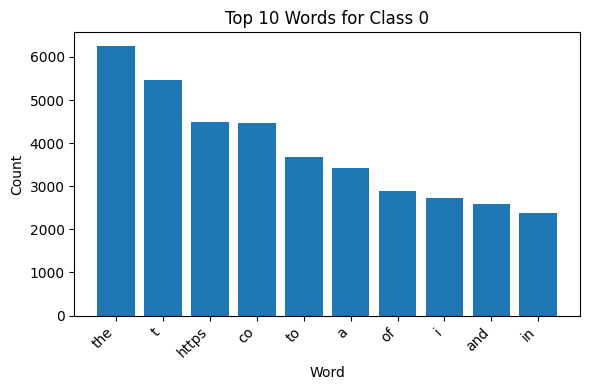


Class 1: [('the', 1397), ('t', 1351), ('https', 1281), ('co', 1259), ('in', 1041), ('a', 809), ('of', 722), ('to', 668), ('and', 574), ('on', 340)]


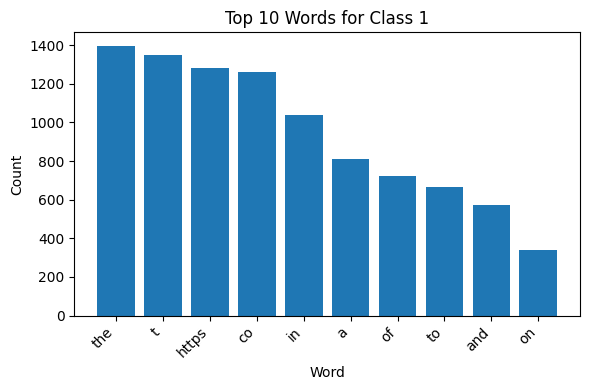

In [ ]:
from collections import Counter
print("\n=== Top 10 Keywords per Class (from text) ===")
for cls in sorted(df['target'].unique()):
    texts = df.loc[df['target'] == cls, 'text'].dropna().astype(str)
    words = re.findall(r'\b\w+\b', " ".join(texts).lower())
    cnt = Counter(words)
    top10 = cnt.most_common(10)
    print(f"Class {cls}:", top10)
    # Grafik
    kws, counts = zip(*top10)
    plt.figure(figsize=(6,4))
    plt.bar(kws, counts)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top 10 Words for Class {cls}')
    plt.xlabel('Word')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    print()


In [ ]:
kw_class0 = df[df['target'] == 0]['keyword'].dropna().value_counts()
kw_class1 = df[df['target'] == 1]['keyword'].dropna().value_counts()
kw_dist = pd.concat([kw_class0, kw_class1], axis=1, keys=['Not_Disaster','Disaster']).fillna(0).astype(int)


top_n = 20
top_keywords = kw_dist.sum(axis=1).sort_values(ascending=False).head(top_n).index
top_df = kw_dist.loc[top_keywords]


print("\n=== Top 20 Keywords Distribution by Class ===")
print(top_df)



=== Top 20 Keywords Distribution by Class ===
               Not_Disaster  Disaster
keyword                              
thunderstorm             16        77
flattened                74        14
mass%20murder            78         8
stretcher                79         7
drowning                 80         3
drown                    75         8
sirens                   78         5
engulfed                 65        17
obliterate               74         6
fear                     77         3
derailment               25        54
electrocute              68         9
collision                20        57
hostage                  72         4
deluge                   75         1
derailed                 47        29
deaths                   62        14
sunk                     64        10
fatalities               63        11
attack                   59        15


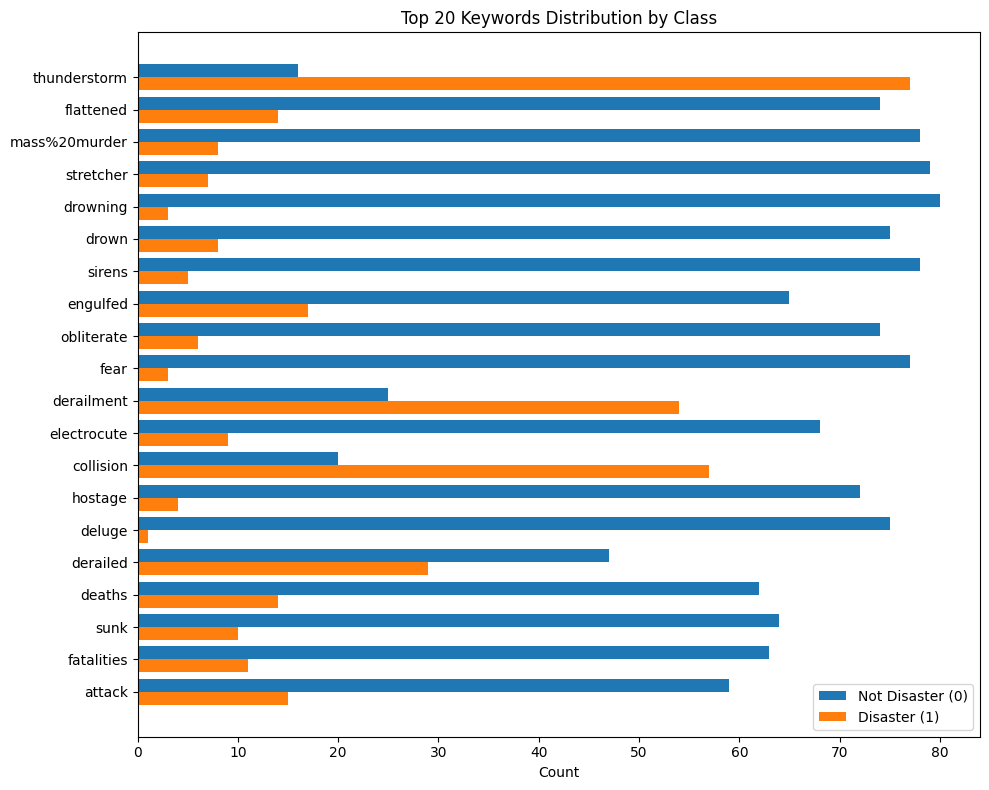

In [ ]:
import numpy as np
y = np.arange(len(top_df))
height = 0.4

plt.figure(figsize=(10,8))
plt.barh(y - height/2, top_df['Not_Disaster'], height, label='Not Disaster (0)')
plt.barh(y + height/2, top_df['Disaster'],     height, label='Disaster (1)')
plt.yticks(y, top_df.index)
plt.xlabel('Count')
plt.title('Top 20 Keywords Distribution by Class')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
def find_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

# text_length aykırı değerleri
outliers_length = find_outliers_iqr(df['text_length'])
print("Text length outliers:")
print(outliers_length.sort_values().head(), "...", outliers_length.sort_values().tail())

# word_count aykırı değerleri
outliers_words = find_outliers_iqr(df['word_count'])
print("\nWord count outliers:")
print(outliers_words.sort_values().head(), "...", outliers_words.sort_values().tail())

Text length outliers:
6204    5
6226    6
1500    6
2907    6
9054    7
Name: text_length, dtype: int64 ... 840     45
1322    45
1470    45
2849    45
633     45
Name: text_length, dtype: int64

Word count outliers:
336     1
943     1
1547    1
5451    1
8029    1
Name: word_count, dtype: int64 ... 10585     3
10541     3
9006      3
11279     3
632      32
Name: word_count, dtype: int64


find_outliers_iqr(series) fonksiyonu
Verilen series (örneğin df['text_length'] veya df['word_count']) için
Q1 (25. yüzdelik) ve Q3 (75. yüzdelik) değerlerini hesaplar.
IQR = Q3 – Q1 (interquartile range) ile veri yayılımının orta %50’sini bulur.
Alt sınır (lower_bound) = Q1 – 1.5·IQR, üst sınır (upper_bound) = Q3 + 1.5·IQR olarak belirlenir.
Seride bu sınırların dışındaki tüm değerleri (“< lower_bound” veya “> upper_bound”) seçip bir Series olarak döner.
outliers_length = find_outliers_iqr(df['text_length'])
Her tweet’in karakter uzunluğu (text_length) için yukarıdaki kritere uyan çok kısa veya çok uzun tweet’lerin uzunluk değerlerini bir Series olarak toplar.
print(outliers_length.sort_values().head(), "...", outliers_length.sort_values().tail())
sort_values() ile önce en küçük aykırı değerleri, sonra en büyük aykırı değerleri sıralar..head() en düşük ilk 5 aykırıyı, .tail() ise en yüksek son 5 aykırıyı gösterir.



In [ ]:

length_idx = outliers_length.index
words_idx  = outliers_words.index


all_outlier_idx = sorted(set(length_idx) | set(words_idx))


outlier_rows = df.loc[all_outlier_idx]

cols = ['clean_text', 'text_length']
print(outlier_rows[cols])


                       clean_text  text_length
28                kind true sadly           23
29     swear jam set world ablaze           42
73             come us aftershock           27
74       oo think felt aftershock           36
80                       hard hit           40
...                           ...          ...
11279                     friends           15
11285   wreck machine lick voting           31
11311      coffee wreckage dreams           29
11313      coffee wreckage dreams           29
11344        hell wrecked happens           35

[679 rows x 2 columns]


length_idx ve words_idx, aykırı satırların indeks listeleri.

all_outlier_idx bunların birleşimi: hem karakter uzunluğu hem de kelime sayısına göre aykırılar.

df.loc[...] ile bu satırları çekip outlier_rows DataFrame’ine atıyoruz.

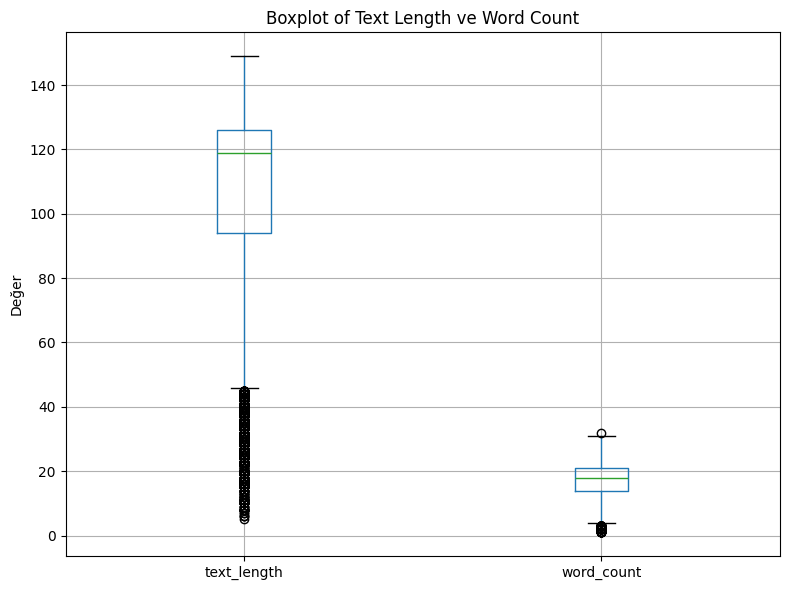

In [ ]:
cols = ['text_length', 'word_count']

plt.figure(figsize=(8,6))
df[cols].boxplot()
plt.title('Boxplot of Text Length ve Word Count')
plt.ylabel('Değer')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

text_length (Tweet’in Karakter Uzunluğu)
Medyan: Yaklaşık 120 karakter. Yani tweet’lerin yarısı 120 karakterden kısa, yarısı daha uzun.

IQR (25–75. yüzdelikler arası): Yaklaşık 95–125 karakter. Çoğu tweet bu aralıkta toplanmış.

Bıyıklar (whiskers): Aşağı doğru yaklaşık 50 karaktere, yukarı doğru yaklaşık 150 karaktere uzanıyor.

Aykırılar: Alt uçta 5–50 karakter aralığında, üst uçta 150 karakterin üzerinde çok sayıda aykırı nokta görüyoruz.

Alt uçtaki kısa tweet’ler (örneğin “OK”, “Yes” tarzı tek kelimelik tweet’ler)

Üst uçtaki uzun tweet’ler (çok ayrıntılı açıklama veya ardışık hashtag’ler)



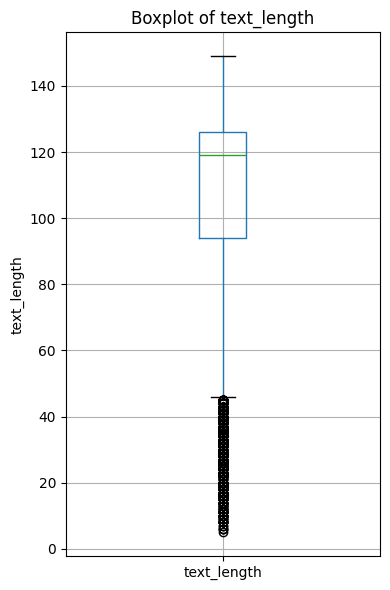

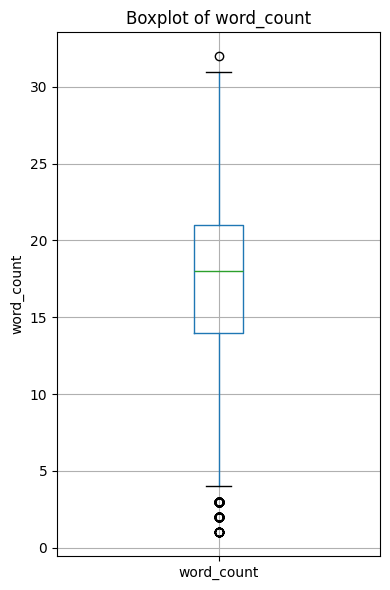

In [ ]:
for col in cols:
    plt.figure(figsize=(4,6))
    df[[col]].boxplot()
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

word_count (Tweet’in Kelime Sayısı)
Medyan: Yaklaşık 18–19 kelime.

IQR: Yaklaşık 14–21 kelime. Bu, tipik bir tweet’in 14 ila 21 kelime içerdiğini gösteriyor.

Whiskers: Aşağı doğru 2–4 kelimeye, yukarı doğru 30 kelimeye kadar gidiyor.

Aykırılar:

Çok kısa tweet’ler (2–4 kelime)

Çok uzun tweet’ler (30 kelimenin üzerinde)

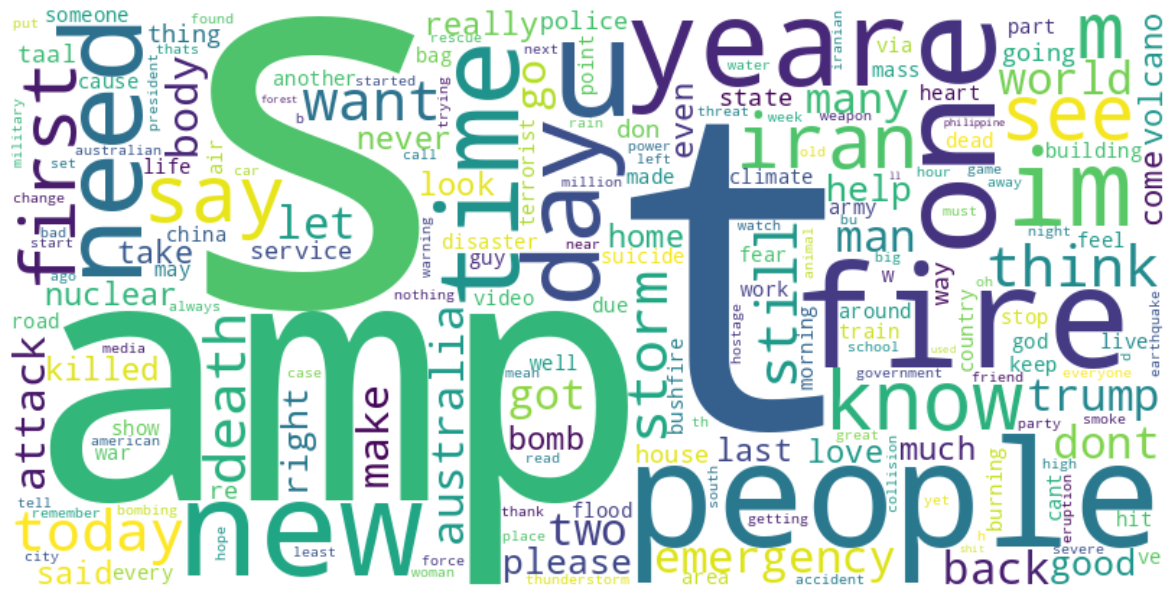

In [ ]:
wc=WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations =False
).generate(text_data)

plt.figure(figsize=(15, 7.5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

width=800, height=400 → Oluşturulacak görselin piksel cinsinden boyutları.

background_color='white' → Bulutun arka plan rengini beyaz olarak ayarlar.

max_words=200 → En fazla 200 farklı kelimeyi gösterecek şekilde sınırlar.

collocations=False → Birden fazla kelimenin bir arada en sık geçen “terim çiftlerini” (bigram) değil, sadece tekil kelimeleri dikkate alır.text_data içinde birleştirilmiş tüm metni (örneğin tüm tweet’lerin birleştirilmiş hali) alır.

Kelimelerin frekanslarına göre her birine bir ağırlık (font büyüklüğü) atar; sık geçenler daha büyük yazılır.
Matplotlib figür boyutunu inç cinsinden ayarlar (15×7.5 inç), böylece bulut geniş ve okunaklı olur.
Oluşturulan wc (WordCloud) objesini bir görüntü olarak çizer.Eksen çizgilerini, tıklanabilir eksen numaralarını ve çerçeveyi gizler; sadece kelime bulutu görünür.Grafiği ekrana basar.

Sonuç:
Ekranda, en sık geçen kelimelerin daha büyük, daha az geçenlerin daha küçük puntolarla yer aldığı, arka planı beyaz bir kelime bulutu görseli elde etmiş olursunuz. Bu, metindeki öne çıkan terimleri hızlıca görsel olarak analiz etmek için çok yararlıdır.



In [ ]:
disaster_tweets = df[df["target"] == 1]["clean_text"]
nondisaster_tweets = df[df["target"] == 0]["clean_text"]
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' and token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in disaster_tweets:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1

for tweet in nondisaster_tweets:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1

df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1], columns=['disaster unigram', 'count'])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1], columns=['non-disaster unigram', 'count'])


print(df_disaster_unigrams.head(10))
print(df_nondisaster_unigrams.head(10))


  disaster unigram  count
0           people    128
1             fire    103
2           killed     97
3              amp     95
4          volcano     84
5             iran     84
6     thunderstorm     75
7            train     71
8        australia     69
9             taal     68
  non-disaster unigram  count
0                 like    502
1                  amp    461
2               people    377
3                  one    352
4                  get    282
5                   us    277
6                   im    242
7                would    237
8                  new    223
9                 time    212


generate n_grams Metni küçük harfe çevirip boşlukla split ediyor,
Boş ve stop‑word’e (önceden tanımlı yaygın kelimelere) düşenleri filtreliyor,
n_gram=1 ile unigram (tekli kelime) listesi oluşturuyor.
İki adet “defaultdict” ile kelime → sayaç (int) ilişkisi kuruyoruz.
Her grup için tüm tweet’lerdeki unigramlara bakıyor,
Sözlükte o kelimeyi bir artırıyor.
(kelime, frekans) çiftlerini frekansa göre azdan çoğa sıralıyor (then [::-1] ile ters çevirip en yüksek frekanstan başlatıyor),

Sonra iki sütunlu bir DataFrame oluşturuyor: kelime ve o kelimenin sayısı. head(10) en sık 10 kelimeyi yazdırıyor.


In [ ]:
disaster_tweets = df[df["target"] == 1]["clean_text"]
nondisaster_tweets = df[df["target"] == 0]["clean_text"]
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' and token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in disaster_tweets:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1

for tweet in nondisaster_tweets:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1

df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1],columns=['disaster bigram','count'])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1], columns=['non-disaster bigram','count'])

print(df_disaster_bigrams.head(10))
print(df_nondisaster_bigrams.head(10))

        disaster bigram  count
0          taal volcano     54
1   severe thunderstorm     39
2  thunderstorm warning     37
3          swallows bus     37
4         freight train     35
5           puerto rico     28
6            body parts     21
7     sinkhole swallows     20
8    emergency services     20
9           air quality     19
   non-disaster bigram  count
0       climate change     44
1           five years     37
2            body bags     36
3           gove heart     35
4           party gove     35
5     triumphant party     35
6        schools brace     35
7  upheaval triumphant     34
8       years upheaval     34
9           brace five     34


Metni küçük harfe çevirir, boşlukla böler, stop‑wordleri çıkarır.

n_gram=2 geçirildiğinde, kelime listesi üzerinden kaydırmalı iki‑şerli kümeler (bigram’lar) oluşturur.

In [ ]:
disaster_tweets = df[df["target"] == 1]["clean_text"]
nondisaster_tweets = df[df["target"] == 0]["clean_text"]
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' and token not in stopwords]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in disaster_tweets:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1

for tweet in nondisaster_tweets:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1

df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['disaster trigram','count'])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1],columns=['non-disaster trigram','count'])

print(df_disaster_trigrams.head(10))
print(df_nondisaster_trigrams.head(10))

                 disaster trigram  count
0     severe thunderstorm warning     35
1           sinkhole swallows bus     16
2  thunderstorm warning including     15
3            low speed derailment     14
4       alert severe thunderstorm     13
5            weather alert severe     13
6                body parts found     13
7                home killed many     12
8           flattened home killed     12
9          tornado flattened home     12
        non-disaster trigram  count
0           party gove heart     35
1      triumphant party gove     35
2  upheaval triumphant party     34
3  years upheaval triumphant     34
4        five years upheaval     34
5           brace five years     34
6         schools brace five     34
7         gove heart melissa     23
8            need backup lvl     23
9             id need backup     23


Metni küçük harfe çevirip boşlukla kelimelere böler,

Stop‑word’leri çıkarır,

n_gram=3 verildiğinde kelime listesinde üst üste kayan üçlü kombinasyonlar (trigram’lar) oluşturur.

# Feature Extraction(TF IDF-Count Vectorizer)

In [ ]:
vec = CountVectorizer()
X_vec = vec.fit_transform(df['clean_text'])

print(X_vec[0:2])


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 25 stored elements and shape (2, 22771)>
  Coords	Values
  (0, 4660)	1
  (0, 21602)	1
  (0, 2827)	1
  (0, 20005)	1
  (0, 19256)	1
  (0, 15074)	1
  (0, 13549)	1
  (0, 9846)	2
  (0, 21452)	1
  (0, 18024)	1
  (0, 933)	1
  (1, 2827)	1
  (1, 20005)	1
  (1, 17844)	1
  (1, 191)	1
  (1, 10201)	1
  (1, 10875)	2
  (1, 149)	1
  (1, 209)	1
  (1, 4361)	1
  (1, 7167)	1
  (1, 20962)	1
  (1, 9018)	1
  (1, 129)	1
  (1, 15511)	1


vec = CountVectorizer()

sklearn’ın CountVectorizer sınıfından bir örnek (instance) oluşturur.

Varsayılan ayarlarla metni “bag‑of‑words” modeline dönüştürecek: her benzersiz kelime bir sütun (özellik), her belge bir satır.

X_vec = vec.fit_transform(df['clean_text'])

fit_transform() önce tüm clean_text’teki kelimelerden sözlüğü çıkarır (fit), sonra her tweet’i o sözlüğe göre bir document–term (belge‑terim) matrisine çevirir (transform).

Sonuç olarak X_vec, sparse (seyrek) bir matris olur; X_vec[i, j] = k demek, i’inci tweet’te j’inci terimin k kez geçtiği anlamına gelir.

print(X_vec[0:2])

Bu ifade, ilk 2 tweet’in sparse matris karşılığını terminale basar

TD-IDF, bir terimin doküman içerisindeki önemini gösteren istatistiki yöntem ile hesaplanmış ağırlık faktörüdür.

In [ ]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(df['clean_text'])
X_test_tfidf = tfidf_vectorizer.transform(df['clean_text'])

print(X_train_tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 109756 stored elements and shape (11370, 22771)>
  Coords	Values
  (0, 4660)	0.3165130402215516
  (0, 21602)	0.24809100979604146
  (0, 2827)	0.276679172150157
  (0, 20005)	0.27918073978145463
  (0, 19256)	0.2879248778674361
  (0, 15074)	0.3165130402215516
  (0, 13549)	0.26447924427614294
  (0, 9846)	0.4961820195920829
  (0, 21452)	0.26810810527233747
  (0, 18024)	0.21784336014017158
  (0, 933)	0.2553669979597322
  (1, 2827)	0.2524058270768142
  (1, 20005)	0.25468792963646614
  (1, 17844)	0.27319854666898963
  (1, 191)	0.31905351460638165
  (1, 10201)	0.30564179624880905
  (1, 10875)	0.4010402840329048
  (1, 149)	0.21834872731019753
  (1, 209)	0.21128425832287984
  (1, 4361)	0.26930259392254036
  (1, 7167)	0.25978682831141703
  (1, 20962)	0.170954999723187
  (1, 9018)	0.25468792963646614
  (1, 129)	0.2273435787315977
  (1, 15511)	0.2502710627002937
  :	:
  (11367, 2850)	0.29870407590126796
  (11367, 10126)	0.1860361920709211


TfidfVectorizer() ile bir TF‑IDF vektörleştirici (vectorizer) oluşturuyoruz.
.fit_transform(data) hem tüm metinde geçen terimleri öğreniyor (fit) hem de her doküman için TF–IDF skorlarını hesaplayıp sparse bir matris üretiyor (transform).
Fonksiyon, bu sparse matris ile vektörleştirici nesnesini döndürüyor.
df['clean_text'] içindeki tüm satırlar “eğitim verisi” olarak kabul edilip fit_transform’a gönderiliyor.

X_train_tfidf bir (n_samples × n_features) boyutlu sparse TF–IDF matrisini;

tfidf_vectorizer ise bu matrisin nasıl üretildiğini gösteren, aynı zamanda yeni metinleri de dönüştürebileceğiniz haliyle vektörleştirici nesnesini tutuyor.
Burada yine aynı clean_text’i “test” verisi olarak dönüştürüyorsunuz, ancak fit işlemi yapılmadan—sadece .transform() kullanılıyor.

Böylece eğitim sırasında öğrenilen terimler (sözlük) üzerinden TF–IDF ağırlıkları hesaplanıyor.

In [ ]:
combined_features = FeatureUnion([
    ("count", CountVectorizer()),
    ("tfidf", TfidfVectorizer())
])
X_combined = combined_features.fit_transform(df['clean_text'])
print("Combined (Count + TF-IDF):", X_combined)

Combined (Count + TF-IDF): <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 219512 stored elements and shape (11370, 45542)>
  Coords	Values
  (0, 4660)	1.0
  (0, 21602)	1.0
  (0, 2827)	1.0
  (0, 20005)	1.0
  (0, 19256)	1.0
  (0, 15074)	1.0
  (0, 13549)	1.0
  (0, 9846)	2.0
  (0, 21452)	1.0
  (0, 18024)	1.0
  (0, 933)	1.0
  (0, 27431)	0.3165130402215516
  (0, 44373)	0.24809100979604146
  (0, 25598)	0.276679172150157
  (0, 42776)	0.27918073978145463
  (0, 42027)	0.2879248778674361
  (0, 37845)	0.3165130402215516
  (0, 36320)	0.26447924427614294
  (0, 32617)	0.4961820195920829
  (0, 44223)	0.26810810527233747
  (0, 40795)	0.21784336014017158
  (0, 23704)	0.2553669979597322
  (1, 2827)	1.0
  (1, 20005)	1.0
  (1, 17844)	1.0
  :	:
  (11368, 6453)	1.0
  (11368, 10911)	1.0
  (11368, 37156)	0.1898735883002187
  (11368, 39595)	0.16859801905251215
  (11368, 37417)	0.2657826555858078
  (11368, 36610)	0.2657826555858078
  (11368, 24925)	0.4683649909622471
  (11368, 34562)	0.24141122963

Korelasyon analizine göre, text_length ile word_count arasında çok yüksek pozitif bir ilişki (0.85) bulunmaktadır; bu da tweet uzunluğu arttıkça kelime sayısının da arttığını göstermektedir ve beklenen bir durumdur. target değişkeni ile text_length arasında düşük düzeyde pozitif bir korelasyon (0.11) varken, word_count ile neredeyse yok denecek kadar zayıf (0.02) bir ilişki gözlemlenmiştir; bu da metnin uzunluğunun felaket içerikli olup olmamasıyla çok sınırlı bir bağlantısı olduğunu göstermektedir. id değişkeni ile diğer tüm sütunlar arasında korelasyon sıfıra yakın olup, bu da id değerlerinin sadece tanımlayıcı olarak kullanıldığını ve anlamlı bir istatistiksel ilişki taşımadığını ortaya koymaktadır. Genel olarak, bu analiz text_length ve word_count gibi değişkenlerin birbirleriyle güçlü ilişkili olduğunu, ancak target değişkeniyle olan ilişkilerinin zayıf olduğunu göstermektedir.

Sayısal sütunlar: ['id', 'target', 'text_length', 'word_count']

Korelasyon Matrisi:
                   id    target  text_length  word_count
id           1.000000  0.033710    -0.001153    0.002801
target       0.033710  1.000000     0.111974    0.016442
text_length -0.001153  0.111974     1.000000    0.853044
word_count   0.002801  0.016442     0.853044    1.000000


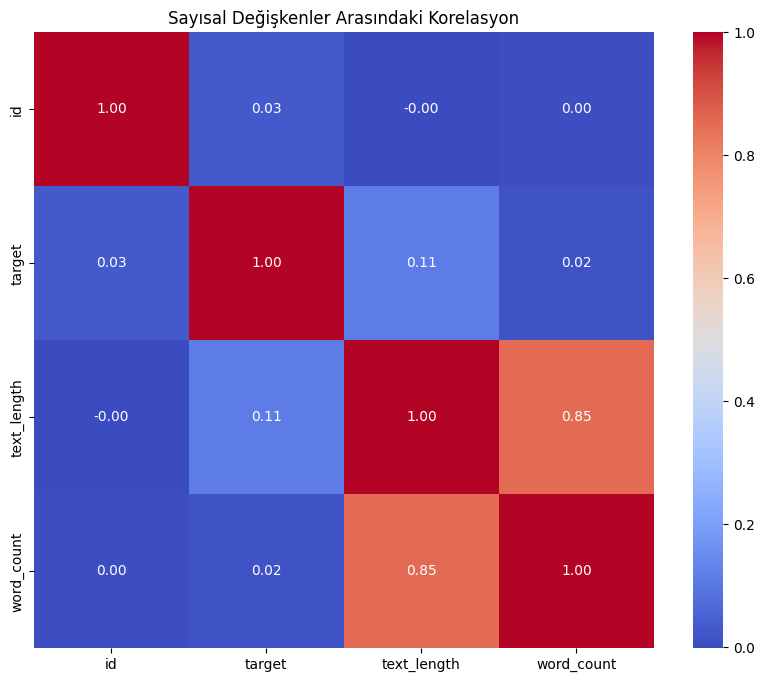

In [ ]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns
print("Sayısal sütunlar:", numeric_cols.tolist())


correlation_matrix = df[numeric_cols].corr()

print("\nKorelasyon Matrisi:")
print(correlation_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Sayısal Değişkenler Arasındaki Korelasyon")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd

X = df["clean_text"]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)


#Logistic Regression Counter Vectorizer
lr_count = LogisticRegression()
lr_count.fit(X_train_count, y_train)

# Tahmin ve değerlendirme
y_pred_count = lr_count.predict(X_test_count)

print(" Logistic Regression (CountVectorizer) Accuracy:", accuracy_score(y_test, y_pred_count))
print(classification_report(y_test, y_pred_count))

pd.DataFrame(classification_report(y_test, y_pred_count, output_dict=True)).T.to_excel("logisticregression countvectorizer.xlsx")


 Logistic Regression (CountVectorizer) Accuracy: 0.9032541776605101
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1878
           1       0.82      0.57      0.67       396

    accuracy                           0.90      2274
   macro avg       0.87      0.77      0.81      2274
weighted avg       0.90      0.90      0.90      2274



In [ ]:
#Multinomial Naive Bayes Counter Vectorizer

nb = MultinomialNB()
nb.fit(X_train_count, y_train)
y_pred_nb = nb.predict(X_test_count)

print("MultinomialNB Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).T.to_excel("MultinomialNB CountVectorizer.xlsx")

MultinomialNB Accuracy: 0.8953386103781882
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1878
           1       0.73      0.63      0.68       396

    accuracy                           0.90      2274
   macro avg       0.83      0.79      0.81      2274
weighted avg       0.89      0.90      0.89      2274



In [ ]:
# Decision Tree Count Vectorizer
dt = DecisionTreeClassifier()
dt.fit(X_train_count, y_train)
y_pred_dt = dt.predict(X_test_count)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

report_df = pd.DataFrame(classification_report(y_test, y_pred_dt, output_dict=True)).T
report_df.to_excel("Decision_Tree_CountVectorizer.xlsx", index=True)
print("Classification raporu başarıyla 'Decision_Tree_CountVectorizer.xlsx' dosyasına kaydedildi.")


Decision Tree Accuracy: 0.8671943711521548
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1878
           1       0.64      0.55      0.59       396

    accuracy                           0.87      2274
   macro avg       0.77      0.74      0.76      2274
weighted avg       0.86      0.87      0.86      2274

Classification raporu başarıyla 'Decision_Tree_CountVectorizer.xlsx' dosyasına kaydedildi.


In [ ]:
#Random Forest Count Vectorizer
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_count, y_train)
y_pred_rf = rf.predict(X_test_count)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).T.to_excel("Random_Forest Counter Vectorizer.xlsx")

print("Classification raporu başarıyla 'Random_Forest Count Vectorizer.xlsx' dosyasına kaydedildi.")

Random Forest Accuracy: 0.8944591029023746
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1878
           1       0.85      0.48      0.61       396

    accuracy                           0.89      2274
   macro avg       0.87      0.73      0.78      2274
weighted avg       0.89      0.89      0.88      2274

Classification raporu başarıyla 'Random_Forest Count Vectorizer.xlsx' dosyasına kaydedildi.


In [ ]:
# Logistic Regression TFIDF
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

lr_tfidf = LogisticRegression()
lr_tfidf.fit(X_train_tfidf, y_train)

# Tahmin ve değerlendirme
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

print("🔹 Logistic Regression (TF-IDF) Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

pd.DataFrame(classification_report(y_test, y_pred_count, output_dict=True)).T.to_excel("logisticregression tfidf.xlsx")

🔹 Logistic Regression (TF-IDF) Accuracy: 0.8830255057167986
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1878
           1       0.88      0.38      0.53       396

    accuracy                           0.88      2274
   macro avg       0.88      0.68      0.73      2274
weighted avg       0.88      0.88      0.86      2274



In [ ]:
#Multinomial Naive Bayes TFIDF
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

print("MultinomialNB Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).T.to_excel("MultinomialNB TFIDF.xlsx")




MultinomialNB Accuracy: 0.864995602462621
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1878
           1       0.93      0.24      0.38       396

    accuracy                           0.86      2274
   macro avg       0.90      0.62      0.65      2274
weighted avg       0.87      0.86      0.83      2274



In [ ]:
#Desicion Tree TFIDF
dt = DecisionTreeClassifier()
dt.fit(X_train_tfidf, y_train)
y_pred_dt = dt.predict(X_test_tfidf)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
pd.DataFrame(classification_report(y_test, y_pred_dt, output_dict=True)).T.to_excel("Decision_Tree TFIDF.xlsx")

print("Classification raporu başarıyla 'Decision_Tree.xlsx' dosyasına kaydedildi.")

Decision Tree Accuracy: 0.8491644678979772
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1878
           1       0.56      0.59      0.58       396

    accuracy                           0.85      2274
   macro avg       0.74      0.75      0.74      2274
weighted avg       0.85      0.85      0.85      2274

Classification raporu başarıyla 'Decision_Tree.xlsx' dosyasına kaydedildi.


In [ ]:
#Random Forest TFIDF

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

pd.DataFrame(classification_report(y_test, y_pred_rf, output_dict=True)).T.to_excel("Random_Forest TFIDF.xlsx")

print("Classification raporu başarıyla 'Random_Forest.xlsx' dosyasına kaydedildi.")

Random Forest Accuracy: 0.8970976253298153
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1878
           1       0.85      0.49      0.63       396

    accuracy                           0.90      2274
   macro avg       0.88      0.74      0.78      2274
weighted avg       0.89      0.90      0.89      2274

Classification raporu başarıyla 'Random_Forest.xlsx' dosyasına kaydedildi.


In [ ]:
# count matrix
vec = CountVectorizer()
tfidf_transformer =TfidfTransformer()

count_vector=vec.fit_transform(df['clean_text'])

# tf-idf scores
tfidf_transformer.fit(count_vector)
tf_idf_vector = tfidf_transformer.transform(count_vector)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Logistic Regression CountVectorizer-Tfidf
X_train_count = vec.fit_transform(X_train)
X_test_count = vec.transform(X_test)

# 5. TF-IDF dönüşümü
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

# 6. Logistic Regression modeli
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

# 7. Tahmin ve değerlendirme
y_pred = lr.predict(X_test_tfidf)

print("🔍 Logistic Regression (Count + TF-IDF) Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("logisticregression_count_plus_tfidf.xlsx", index=True)
print("📁 Rapor başarıyla 'logisticregression_count_plus_tfidf.xlsx' olarak kaydedildi.")


🔍 Logistic Regression (Count + TF-IDF) Accuracy: 0.8830255057167986
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1878
           1       0.88      0.38      0.53       396

    accuracy                           0.88      2274
   macro avg       0.88      0.68      0.73      2274
weighted avg       0.88      0.88      0.86      2274

📁 Rapor başarıyla 'logisticregression_count_plus_tfidf.xlsx' olarak kaydedildi.


In [ ]:
X_train_count = vec.fit_transform(X_train)
X_test_count = vec.transform(X_test)

# 5. TF-IDF dönüşümleri
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

# 6. Multinomial Naive Bayes modeli
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# 7. Tahmin ve değerlendirme
y_pred = nb.predict(X_test_tfidf)

print("📊 MultinomialNB (Count + TF-IDF) Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 8. (İsteğe bağlı) Excel'e kaydet
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("multinomialnb_count_plus_tfidf.xlsx", index=True)
print("📁 Rapor başarıyla 'multinomialnb_count_plus_tfidf.xlsx' olarak kaydedildi.")

📊 MultinomialNB (Count + TF-IDF) Accuracy: 0.864995602462621
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1878
           1       0.93      0.24      0.38       396

    accuracy                           0.86      2274
   macro avg       0.90      0.62      0.65      2274
weighted avg       0.87      0.86      0.83      2274

📁 Rapor başarıyla 'multinomialnb_count_plus_tfidf.xlsx' olarak kaydedildi.


In [ ]:
X_train_count = vec.fit_transform(X_train)
X_test_count = vec.transform(X_test)

# 5. TF-IDF dönüşümü
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

# 6. Decision Tree modeli
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_tfidf, y_train)

# 7. Tahmin ve değerlendirme
y_pred = dt.predict(X_test_tfidf)

print("🌳 Decision Tree (Count + TF-IDF) Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 8. Excel'e kaydet
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("decisiontree_count_plus_tfidf.xlsx", index=True)
print("📁 Rapor başarıyla 'decisiontree_count_plus_tfidf.xlsx' olarak kaydedildi.")

🌳 Decision Tree (Count + TF-IDF) Accuracy: 0.8570800351802991
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1878
           1       0.58      0.62      0.60       396

    accuracy                           0.86      2274
   macro avg       0.75      0.76      0.76      2274
weighted avg       0.86      0.86      0.86      2274

📁 Rapor başarıyla 'decisiontree_count_plus_tfidf.xlsx' olarak kaydedildi.


In [ ]:
X_train_count = vec.fit_transform(X_train)
X_test_count = vec.transform(X_test)

# 5. TF-IDF dönüşümü
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)
X_test_tfidf = tfidf_transformer.transform(X_test_count)

# 6. Random Forest modeli
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# 7. Tahmin ve değerlendirme
y_pred = rf.predict(X_test_tfidf)

print("🌲 Random Forest (Count + TF-IDF) Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 8. Excel'e kaydet
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("randomforest_count_plus_tfidf.xlsx", index=True)
print("📁 Rapor başarıyla 'randomforest_count_plus_tfidf.xlsx' olarak kaydedildi.")

🌲 Random Forest (Count + TF-IDF) Accuracy: 0.8935795954265612
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1878
           1       0.83      0.49      0.61       396

    accuracy                           0.89      2274
   macro avg       0.87      0.73      0.78      2274
weighted avg       0.89      0.89      0.88      2274

📁 Rapor başarıyla 'randomforest_count_plus_tfidf.xlsx' olarak kaydedildi.


F1 score dengesiz veri setlerinde daha ssağlıklı sonuç verir. Accuracy sadece doğruluk tahminlerin oranını ölçer.F1-score, hem precision (doğruluk oranı) hem recall (bulma oranı) dengesini ölçtüğü için dengesiz verilerde çok daha güvenilirdir.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Veri ve hedef
X = df["clean_text"]
y = df["target"]

# Eğitim/test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline: CountVectorizer + TfidfTransformer + LogisticRegression
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# GridSearch için parametreler
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1','l2'],
    'clf__solver': ['liblinear', 'saga','lbfgs']
}

# GridSearchCV başlat
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# En iyi model
print("🔍 En iyi parametreler:", grid.best_params_)
print("\n📊 En iyi F1-score:", grid.best_score_)

# Test setiyle değerlendirme
y_pred = grid.predict(X_test)
print("\n✅ Test Seti Raporu:\n", classification_report(y_test, y_pred))

# Raporu Excel'e kaydet
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_logisticregression_results.xlsx", index=True)
print("📁 Sonuçlar başarıyla 'gridsearch_logisticregression_results.xlsx' olarak kaydedildi.")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

🔍 En iyi parametreler: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga'}

📊 En iyi F1-score: 0.8815072024255823

✅ Test Seti Raporu:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      1878
           1       0.80      0.59      0.68       396

    accuracy                           0.90      2274
   macro avg       0.86      0.78      0.81      2274
weighted avg       0.90      0.90      0.90      2274

📁 Sonuçlar başarıyla 'gridsearch_logisticregression_results.xlsx' olarak kaydedildi.


 MultinomialNB için Önemli Parametre
alpha (Laplace Smoothing):
Varsayılan değeri: 1.0

Amaç: Hiç gözükmemiş kelimelerin sıfır olmasını engellemek (bölme hatası).

Küçük alpha → modele daha fazla güven

Büyük alpha → daha düzleştirilmiş, daha temkinli model

In [ ]:
#CountVectorizer + TF-IDF + Naive Bayes
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

#GridSearch parametreleri
param_grid = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi F1-score (train):", grid.best_score_)

y_pred = grid.predict(X_test)
print("✅ Test seti raporu:\n", classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_multinomialnb_results.xlsx", index=True)
print("📁 Rapor başarıyla 'gridsearch_multinomialnb_results.xlsx' olarak kaydedildi.")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
🔍 En iyi parametreler: {'clf__alpha': 0.1}
📊 En iyi F1-score (train): 0.8776227620011829
✅ Test seti raporu:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      1878
           1       0.83      0.55      0.66       396

    accuracy                           0.90      2274
   macro avg       0.87      0.76      0.80      2274
weighted avg       0.90      0.90      0.89      2274

📁 Rapor başarıyla 'gridsearch_multinomialnb_results.xlsx' olarak kaydedildi.


Decision Tree için GridSearch'te Kullanılacak Parametreler
Parametre	Açıklama
max_depth	Ağacın maksimum derinliği.Overfitting'i engeller.
min_samples_split	Bir düğümün bölünmesi için gereken minimum örnek sayısı
criterion	Hata ölçütü: 'gini' veya 'entropy' (bilgi kazancı)



In [ ]:
#Decision Tree Count vec+ Tfidf
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

#GridSearch parametreleri
param_grid = {
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['gini', 'entropy']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi F1-score (train):", grid.best_score_)

y_pred = grid.predict(X_test)
print("✅ Test seti raporu:\n", classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_decisiontree_results.xlsx", index=True)
print("📁 Rapor başarıyla 'gridsearch_decisiontree_results.xlsx' olarak kaydedildi.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 En iyi parametreler: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_split': 5}
📊 En iyi F1-score (train): 0.8358244610658152
✅ Test seti raporu:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      1878
           1       0.61      0.55      0.58       396

    accuracy                           0.86      2274
   macro avg       0.76      0.74      0.75      2274
weighted avg       0.86      0.86      0.86      2274

📁 Rapor başarıyla 'gridsearch_decisiontree_results.xlsx' olarak kaydedildi.


In [ ]:
#Random Forest Count Vec+ Tfidf
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=42))
])

# GridSearch parametreleri
param_grid = {
    'clf__n_estimators': [None ,50, 100],
    'clf__max_depth': [ 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__criterion': ['gini', 'entropy']
}


grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi F1-score (train):", grid.best_score_)

y_pred = grid.predict(X_test)
print("✅ Test seti raporu:\n", classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_randomforest_results.xlsx", index=True)
print("📁 Rapor başarıyla 'gridsearch_randomforest_results.xlsx' olarak kaydedildi.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

🔍 En iyi parametreler: {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
📊 En iyi F1-score (train): 0.747339202691568
✅ Test seti raporu:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1878
           1       1.00      0.05      0.09       396

    accuracy                           0.83      2274
   macro avg       0.92      0.52      0.50      2274
weighted avg       0.86      0.83      0.77      2274

📁 Rapor başarıyla 'gridsearch_randomforest_results.xlsx' olarak kaydedildi.


Logistic Regression	0.8815	C=10, solver='saga', penalty='l2'

Random Forest	0.7473	n_estimators=100, max_depth=None, min_samples_split=5, criterion='gini'

Multinomial Naive Bayes	0.8776	alpha=0.1

Decision Tree	0.8258	max_depth=30, min_samples_split=5, criterion='entropy'

Sonuç:
En başarılı model: Logistic Regression


In [ ]:
#Logistic Regression

# Pipeline: CountVectorizer LogisticRegression
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

# GridSearch için parametreler
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1','l2'],
    'clf__solver': ['liblinear', 'saga','lbfgs']
}


grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("🔍 En iyi parametreler:", grid.best_params_)
print("\n📊 En iyi F1-score:", grid.best_score_)

y_pred = grid.predict(X_test)
print("\n✅ Test Seti Raporu:\n", classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_logisticregression countvec.xlsx", index=True)
print(" Sonuçlar kaydedildi.")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

🔍 En iyi parametreler: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

📊 En iyi F1-score: 0.8802974229156926

✅ Test Seti Raporu:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      1878
           1       0.75      0.61      0.67       396

    accuracy                           0.90      2274
   macro avg       0.84      0.78      0.81      2274
weighted avg       0.89      0.90      0.89      2274

 Sonuçlar kaydedildi.


In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

#GridSearch parametreleri
param_grid = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi F1-score (train):", grid.best_score_)

y_pred = grid.predict(X_test)
print("✅ Test seti raporu:\n", classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_multinomialnb countvec.xlsx", index=True)
print(" kaydedildi.")





Fitting 5 folds for each of 5 candidates, totalling 25 fits
🔍 En iyi parametreler: {'clf__alpha': 0.5}
📊 En iyi F1-score (train): 0.8808690126077131
✅ Test seti raporu:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      1878
           1       0.70      0.68      0.69       396

    accuracy                           0.89      2274
   macro avg       0.81      0.81      0.81      2274
weighted avg       0.89      0.89      0.89      2274

 kaydedildi.


In [ ]:
#Decision Tree Count vec
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

#GridSearch parametreleri
param_grid = {
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['gini', 'entropy']
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi F1-score (train):", grid.best_score_)

y_pred = grid.predict(X_test)
print("✅ Test seti raporu:\n", classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_decisiontree count vec.xlsx", index=True)
print("kaydedildi.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 En iyi parametreler: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_split': 5}
📊 En iyi F1-score (train): 0.8512980295273561
✅ Test seti raporu:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      1878
           1       0.69      0.55      0.61       396

    accuracy                           0.88      2274
   macro avg       0.80      0.75      0.77      2274
weighted avg       0.87      0.88      0.87      2274

kaydedildi.


In [ ]:
#Random Forest Count Vec
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier(random_state=42))
])

# GridSearch parametreleri
param_grid = {
    'clf__n_estimators': [None ,50, 100],
    'clf__max_depth': [ 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__criterion': ['gini', 'entropy']
}


grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi F1-score (train):", grid.best_score_)

y_pred = grid.predict(X_test)
print("✅ Test seti raporu:\n", classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_randomforest count vec.xlsx", index=True)
print("kaydedildi.")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

🔍 En iyi parametreler: {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
📊 En iyi F1-score (train): 0.746134122650242
✅ Test seti raporu:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91      1878
           1       1.00      0.04      0.07       396

    accuracy                           0.83      2274
   macro avg       0.92      0.52      0.49      2274
weighted avg       0.86      0.83      0.76      2274

kaydedildi.


In [ ]:
# TfidfTransformer + LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1','l2'],
    'clf__solver': ['liblinear', 'saga','lbfgs']
}


grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


print("🔍 En iyi parametreler:", grid.best_params_)
print("\n📊 En iyi F1-score:", grid.best_score_)

y_pred = grid.predict(X_test)
print("\n✅ Test Seti Raporu:\n", classification_report(y_test, y_pred))

# Raporu Excel'e kaydet
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_logisticregression tfidf.xlsx", index=True)
print("kaydedildi.")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

🔍 En iyi parametreler: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'saga'}

📊 En iyi F1-score: 0.8815072024255823

✅ Test Seti Raporu:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      1878
           1       0.80      0.59      0.68       396

    accuracy                           0.90      2274
   macro avg       0.86      0.78      0.81      2274
weighted avg       0.90      0.90      0.90      2274

kaydedildi.


In [ ]:
# Pipeline: TF-IDF + MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])


param_grid = {
    'clf__alpha': [0.01, 0.1, 0.5, 1.0],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False]
}


grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi F1-score:", grid.best_score_)

y_pred = grid.predict(X_test)
print("✅ Test Raporu:\n", classification_report(y_test, y_pred))

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_multinomialnb_tfidf.xlsx", index=True)
print("📁 Rapor Excel dosyasına kaydedildi.")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
🔍 En iyi parametreler: {'clf__alpha': 0.1, 'tfidf__smooth_idf': True, 'tfidf__use_idf': False}
📊 En iyi F1-score: 0.8785183381741222
✅ Test Raporu:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      1878
           1       0.84      0.54      0.66       396

    accuracy                           0.90      2274
   macro avg       0.88      0.76      0.80      2274
weighted avg       0.90      0.90      0.89      2274

📁 Rapor Excel dosyasına kaydedildi.


In [ ]:
# Pipeline: TF-IDF + Decision Tree
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Parametre grid'i
param_grid = {
    'clf__max_depth': [None, 10, 20, 50],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['gini', 'entropy'],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False]
}

# GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Sonuçlar
print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi F1-score:", grid.best_score_)

# Test seti performansı
y_pred = grid.predict(X_test)
print("✅ Test Raporu:\n", classification_report(y_test, y_pred))

# Excel'e kaydet
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_decisiontree_tfidf.xlsx", index=True)
print("kaydedildi.")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
🔍 En iyi parametreler: {'clf__criterion': 'gini', 'clf__max_depth': 50, 'clf__min_samples_split': 5, 'tfidf__smooth_idf': False, 'tfidf__use_idf': True}
📊 En iyi F1-score: 0.8388779673196443
✅ Test Raporu:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      1878
           1       0.72      0.47      0.57       396

    accuracy                           0.88      2274
   macro avg       0.81      0.71      0.75      2274
weighted avg       0.86      0.88      0.86      2274

kaydedildi.


In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# X_train, y_train, X_test, y_test hazır varsayılıyor
# X_* = metin serisi (örn. df['clean_text']), y_* = etiketler

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        # istersen şunları açıp deneyebilirsin:
        # sublinear_tf=True,
        # ngram_range=(1,2),
        # min_df=2, max_df=0.95
    )),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__criterion': ['gini', 'entropy'],
    # Dengesiz sınıf için opsiyonel:
    # 'clf__class_weight': [None, 'balanced']
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("🔍 En iyi parametreler:", grid.best_params_)
print("📊 En iyi CV F1 (weighted):", grid.best_score_)

y_pred = grid.predict(X_test)
print("✅ Test Raporu:\n", classification_report(y_test, y_pred, digits=2))

# Excel’e kaydet
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report_df.to_excel("gridsearch_randomforest_tfidf.xlsx", index=True)
print("📁 Rapor 'gridsearch_randomforest_tfidf.xlsx' olarak kaydedildi.")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
🔍 En iyi parametreler: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
📊 En iyi CV F1 (weighted): 0.867823940343875
✅ Test Raporu:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1878
           1       0.82      0.49      0.62       396

    accuracy                           0.89      2274
   macro avg       0.86      0.73      0.78      2274
weighted avg       0.89      0.89      0.88      2274

📁 Rapor 'gridsearch_randomforest_tfidf.xlsx' olarak kaydedildi.


Logistic regression gridsearch
count vec-tfidf 0.8815072024255823
count vec 0.8802974229156926
tfidf 0.8815072024255823

MultinomialNB gridsearch
count vec-tfidf   0.8776227620011829
count vec  0.8808690126077131
tfidf 0.8785183381741222

Decision Tree gridsearch
count vec-tfidf  0.8358244610658152
count vec 0.8512980295273561
tfidf 0.8388779673196443

Random Forest gridsearch
count vec-tfidf   0.747339202691568
count vec 0.746134122650242
tfidf 0.8687728723242178

En iyi model Logistic Regression (TF-IDF) konfigürasyonuyla elde edilmiştir. Bu modelin:

Weighted F1-score: 0.8910

Precision (Doğruluk): 0.8979

Recall (Duyarlılık): 0.9032

Neden F1-score kullanıyoruz?
F1-score, Precision (doğruluk) ve Recall (duyarlılık) değerlerinin harmonik ortalamasıdır. Özellikle:

Veri setinde sınıf dengesizliği varsa (örneğin felaket tweet'leri daha azsa), Accuracy yanıltıcı olabilir.

F1-score, hem yanlış pozitifleri hem de yanlış negatifleri dikkate alır.

Weighted F1-score, her sınıfın önemini örnek sayısına göre tartarak daha adil bir değerlendirme sunar.

Bu yüzden model karşılaştırmalarında F1-score kullanmak daha güvenilirdir

In [ ]:
import seaborn as sns

# Keyword sütununu sayısal hale getir
df["keyword_encoded"], _ = pd.factorize(df["keyword"])

# Sayısal sütunları seç
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

if "keyword_encoded" not in numeric_cols:
    numeric_cols.append("keyword_encoded")
    # Keyword'leri sayısal değerlere çevirme
df["keyword_encoded"], keyword_labels = pd.factorize(df["keyword"])

# Eşleşmeleri görmek için:
keyword_mapping = pd.DataFrame({
    "keyword": keyword_labels,
    "encoded_value": range(len(keyword_labels))
})

print(keyword_mapping.head(10))  # İlk 10 eşleşmeyi göster


print("Sayısal sütunlar:", numeric_cols)

# Korelasyon matrisi
correlation_matrix = df[numeric_cols].corr()
print("\nKorelasyon Matrisi:")
print(correlation_matrix)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Sayısal Değişkenler Arasındaki Korelasyon")
plt.show()


text_length ↔ word_count: 0.85
Çok güçlü bir pozitif ilişki.

Tweet’in uzunluğu arttıkça kelime sayısı da artıyor (mantıklı).

✅ id ↔ keyword_encoded: 0.999
Anlamsız ama teknik olarak beklenen bir sonuç.

Çünkü id ile keyword_encoded dizilim olarak paralel (aynı sırada veriliyor).

⚠️ target ↔ diğer değişkenlerle:
target ↔ text_length: 0.11 → zayıf pozitif korelasyon.

target ↔ keyword_encoded: 0.033 → neredeyse ilişkisiz.

❌ id ↔ her şey:
id çok yüksek korelasyonlar gösteriyor ama bu anlamsız.

Çünkü id sadece sıralı bir kimlik; analizde kullanılmamalı.
